In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
# Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
 
# Sci-kit learn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Set pandas as the default output for sklearn
from sklearn import set_config
pd.set_option('display.max_columns', None)
set_config(transform_output='pandas')

In [2]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [3]:
# Bringing in housing data
df = pd.read_csv("Data/train.csv", index_col="Id")
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Combining .info with checks for null total and duplicate rows
nulls = df.isna().sum().sum()
print(f'\nmissing values: {nulls}', df.info())
print('duplicated rows', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
# Checking stats on our numeric data
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
# There's nothing too extraordinary
# We need values of object columns to differentiate ordinal from categorical
# Making loop
for col in object_cols:
    print(f"Value counts for column {col}:\n{df[col].value_counts()}\n")

Value counts for column MSZoning:
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Value counts for column Street:
Pave    1454
Grvl       6
Name: Street, dtype: int64

Value counts for column Alley:
Grvl    50
Pave    41
Name: Alley, dtype: int64

Value counts for column LotShape:
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

Value counts for column LandContour:
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

Value counts for column Utilities:
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

Value counts for column LotConfig:
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

Value counts for column LandSlope:
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

Value counts for column Neighborhood:
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert

In [10]:
# The following features are to be removed for being quasi-constant with ~ 95% values as a single value.
# Several features are mostly empty and should also be excluded from analysis.
drop_cols = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature','Street','Utilities',
             'LandSlope','Condition2','RoofMatl','Heating',
             'CentralAir','Functional','GarageQual','GarageCond','PavedDrive']

In [11]:
# Train test splitting.
target = 'SalePrice'
X = df.drop(columns = [target, *drop_cols]).copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=28)
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
503,20,RL,70.0,9170,Reg,Lvl,Corner,Edwards,Feedr,1Fam,1Story,5,7,1965,1965,Hip,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,698,GLQ,96,420,1214,Ex,SBrkr,1214,0,0,1214,1,0,1,0,2,1,TA,6,0,Detchd,1965.0,Unf,2,461,0,0,184,0,0,0,400,4,2007,WD,Normal
453,60,RL,NaN,9303,IR1,Lvl,Corner,Timber,Norm,1Fam,2Story,6,5,1996,1997,Hip,VinylSd,VinylSd,BrkFace,42.0,Gd,TA,PConc,Ex,TA,No,ALQ,742,Unf,0,130,872,Ex,SBrkr,888,868,0,1756,1,0,2,1,3,1,TA,7,0,Attchd,1996.0,Fin,2,422,144,122,0,0,0,0,0,7,2007,WD,Normal
1211,60,RL,70.0,11218,Reg,Lvl,Inside,SawyerW,Norm,1Fam,2Story,6,5,1992,1992,Gable,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1055,1055,Ex,SBrkr,1055,790,0,1845,0,0,2,1,3,1,Gd,8,1,Attchd,1992.0,RFn,2,462,635,104,0,0,0,0,400,5,2010,WD,Normal
672,70,RH,54.0,6629,Reg,Lvl,Inside,Edwards,Artery,1Fam,2Story,6,6,1925,1950,Gambrel,Wd Sdng,Wd Sdng,None,0.0,TA,Gd,BrkTil,TA,TA,No,BLQ,551,Unf,0,121,672,TA,SBrkr,697,672,0,1369,1,0,2,0,3,1,TA,6,0,Detchd,1930.0,Unf,1,300,147,0,0,0,0,0,0,7,2009,WD,Normal
487,20,RL,79.0,10289,Reg,Lvl,Inside,NAmes,Norm,1Fam,1Story,5,7,1965,1965,Hip,MetalSd,MetalSd,BrkFace,168.0,TA,TA,CBlock,TA,TA,No,ALQ,836,Unf,0,237,1073,TA,SBrkr,1073,0,0,1073,1,0,1,1,3,1,TA,6,0,Attchd,1965.0,RFn,2,515,0,0,0,0,0,0,0,6,2007,WD,Normal


In [18]:
# PREPROCESSING PIPELINE FOR ORDINAL DATA
# Making list of ordinal columns
ord_cols = ['LotShape','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'ExterCond','HeatingQC','KitchenQual','GarageFinish','Electrical']
# Create imputer for ordinal data 
impute_na_ord = SimpleImputer(strategy='most_frequent')
## Making the OrdinalEncoder
# Specifying order of categories for our  Ordinal Qual/Cond Columms
lotshape_order = ['IR3','IR2','IR1','Reg']
qual_cond_order = ['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']
exposure_order = ['NA','No','Mn','Av','Gd']
bsmt_fin_order = ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
garage_order = ['NA','Unf','RFn','Fin']
electric_order = ['Mix','FuseP','FuseF','FuseA','SBrkr']
# Making the list of order lists for OrdinalEncoder
ordinal_category_orders = [lotshape_order, qual_cond_order, qual_cond_order, qual_cond_order, exposure_order,
                           bsmt_fin_order, bsmt_fin_order, qual_cond_order, qual_cond_order, qual_cond_order,
                          garage_order, electric_order]                           
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
# Making a final scaler to scale category #'s
scaler = StandardScaler()
## Making an ord_pipe 
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler)
ord_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['IR3', 'IR2', 'IR1', 'Reg'],
                                            ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['NA', 'No', 'Mn', 'Av', 'Gd'],
                                            ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ',
                                             'ALQ', 'GLQ'],
                                            ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ',
                                             'ALQ', 'GLQ'],
                                            ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['NA', 'Unf', 'RFn', 'Fin'],
                                            ['Mix', 'FuseP', 'FuseF', 'FuseA',
                                             'SBrkr']])),
                ('standardscaler', StandardScaler())])

In [19]:
# Making an ordinal_tuple for ColumnTransformer
ord_tuple = ('ordinal', ord_pipe, ord_cols)

In [20]:
# lists of columns for transformer
cat_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
num_cols = X_train.select_dtypes('number').columns

# PREPROCESSING PIPELINE FOR NUMERIC DATA

# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)


# PREPROCESSING PIPELINE FOR ONE-HOT-ENCODED DATA

# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, cat_cols)
# Instantiate with verbose_feature_names_out=False
col_transformer = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)
# Fit and transform the training data
X_train_tf = col_transformer.fit_transform(X_train)
# Transform the testing data
X_test_tf = col_transformer.transform(X_test)
# View the processed training data
X_train_tf.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotShape,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,ExterCond,HeatingQC,KitchenQual,GarageFinish,Electrical,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_nan,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_nan,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
503,-0.866571,-0.003932,-0.138374,-0.790812,1.298783,-0.221013,-0.965831,-0.580972,0.559190,0.309278,-0.331908,0.357365,0.134120,-0.787707,-0.122088,-0.584207,1.110391,-0.243376,-1.010863,-0.761765,-1.050617,-0.198044,-0.312532,-0.939638,-0.572127,0.312749,-0.053263,-0.764878,-0.691203,2.739243,-0.121733,-0.274932,-0.067472,0.611368,-0.860067,-0.594148,0.692017,-0.690228,-0.845492,-0.056803,-0.63787,0.610395,5.376793,-0.234305,0.888551,-0.756714,-0.943125,0.285761,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

In [21]:
# Define shape
input_shape = X_train_tf.shape[1]
input_shape

177

# First Model

In [32]:
# Build regression model within function
def build_model():
    # Instantiate Model 
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(177, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dropout(.5))
    model.add(Dense(80, 
                activation = 'relu'))
    model.add(Dropout(.5))
    model.add(Dense(1, activation = 'linear'))
    
    # Compile Model
    model.compile(loss = 'mse', optimizer = 'adam',
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model

In [33]:
# Call our build function to build model
reg_model = build_model()

# Get model summary
reg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 177)               31506     
                                                                 
 dropout_2 (Dropout)         (None, 177)               0         
                                                                 
 dense_7 (Dense)             (None, 80)                14240     
                                                                 
 dropout_3 (Dropout)         (None, 80)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 81        
                                                                 
Total params: 45,827
Trainable params: 45,827
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = reg_model.fit(X_train_tf, y_train,
                        validation_split = .2,
                        epochs=100,
                        verbose=0) #, callbacks = [early_stop]

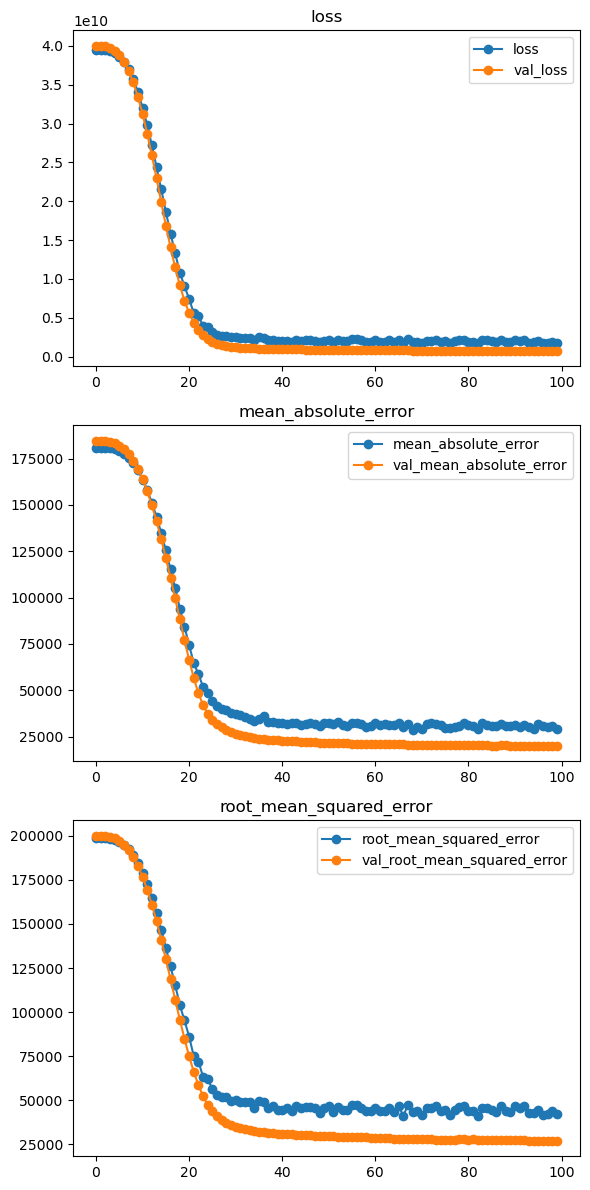

In [35]:
# plot learning 
plot_history(history);

In [27]:
# evaluate model
y_pred = reg_model.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

12/12 [==============================] - 0s 1ms/step
final RMSE: 131388.0778721375
final MAE: 123564.57005730199
final R2: -2.124307508881846


# Second Model

In [36]:
# Let's add two more layers with dropout to see if we can't get stronger metrics
def build_model():
    # Instantiate Model 
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(177, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dropout(.5))
    model.add(Dense(80, 
                activation = 'relu'))
    model.add(Dropout(.5))
    model.add(Dense(40, 
                activation = 'relu'))
    model.add(Dense(20, 
                activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))
    
    # Compile Model
    model.compile(loss = 'mse', optimizer = 'adam',
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model

In [37]:
# Call our build function to build model
reg_model = build_model()

# Get model summary
reg_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 177)               31506     
                                                                 
 dropout_4 (Dropout)         (None, 177)               0         
                                                                 
 dense_10 (Dense)            (None, 80)                14240     
                                                                 
 dropout_5 (Dropout)         (None, 80)                0         
                                                                 
 dense_11 (Dense)            (None, 40)                3240      
                                                                 
 dense_12 (Dense)            (None, 20)                820       
                                                                 
 dense_13 (Dense)            (None, 1)                

In [38]:
history = reg_model.fit(X_train_tf, y_train,
                        validation_split = .2,
                        epochs=100,
                        verbose=0) #, callbacks = [early_stop]

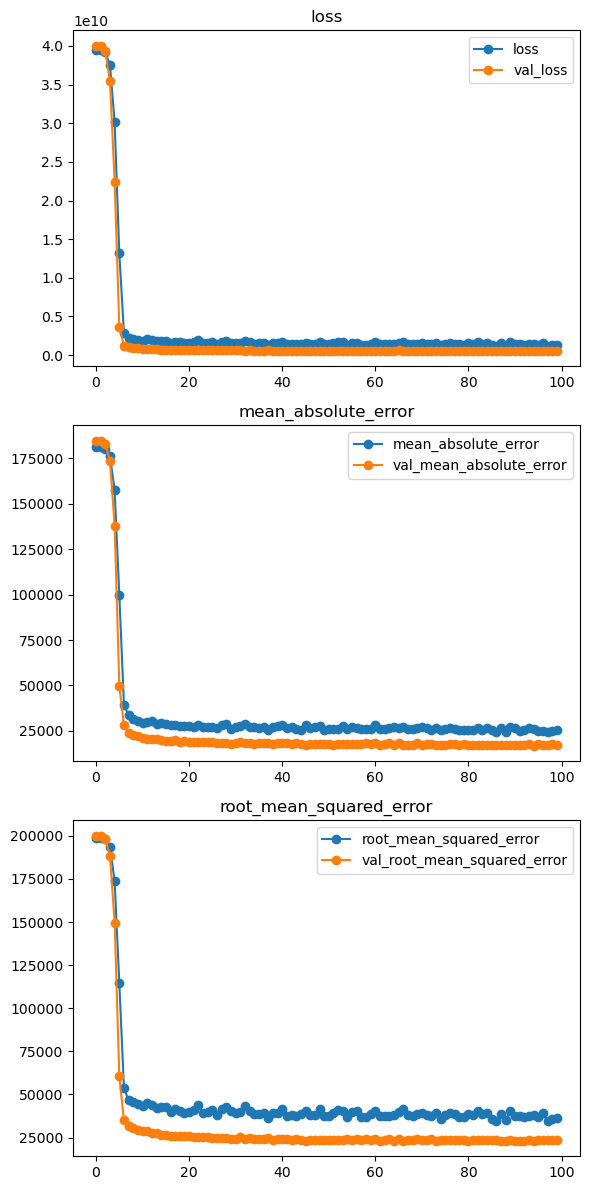

In [39]:
# plot learning 
plot_history(history);

In [40]:
# evaluate model
y_pred = reg_model.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

12/12 [==============================] - 0s 2ms/step
final RMSE: 44038.787858792966
final MAE: 17536.321682363014
final R2: 0.6489955942475866


# Third Model

In [47]:
# Like the above model but with another optimizer
def build_model():
    # Instantiate Model 
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(177, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dropout(.5))
    model.add(Dense(80, 
                activation = 'relu'))
    model.add(Dropout(.5))
    model.add(Dense(40, 
                activation = 'relu'))
    model.add(Dense(20, 
                activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))
    
    # Compile Model
    model.compile(loss = 'mse', optimizer = 'ftrl',
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model

In [48]:
# Call our build function to build model
reg_model = build_model()

# Get model summary
reg_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 177)               31506     
                                                                 
 dropout_10 (Dropout)        (None, 177)               0         
                                                                 
 dense_25 (Dense)            (None, 80)                14240     
                                                                 
 dropout_11 (Dropout)        (None, 80)                0         
                                                                 
 dense_26 (Dense)            (None, 40)                3240      
                                                                 
 dense_27 (Dense)            (None, 20)                820       
                                                                 
 dense_28 (Dense)            (None, 1)                

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [51]:
history = reg_model.fit(X_train_tf, y_train,
                        validation_split = .2,
                        epochs=200,
                        verbose=0) #, callbacks = [early_stop]

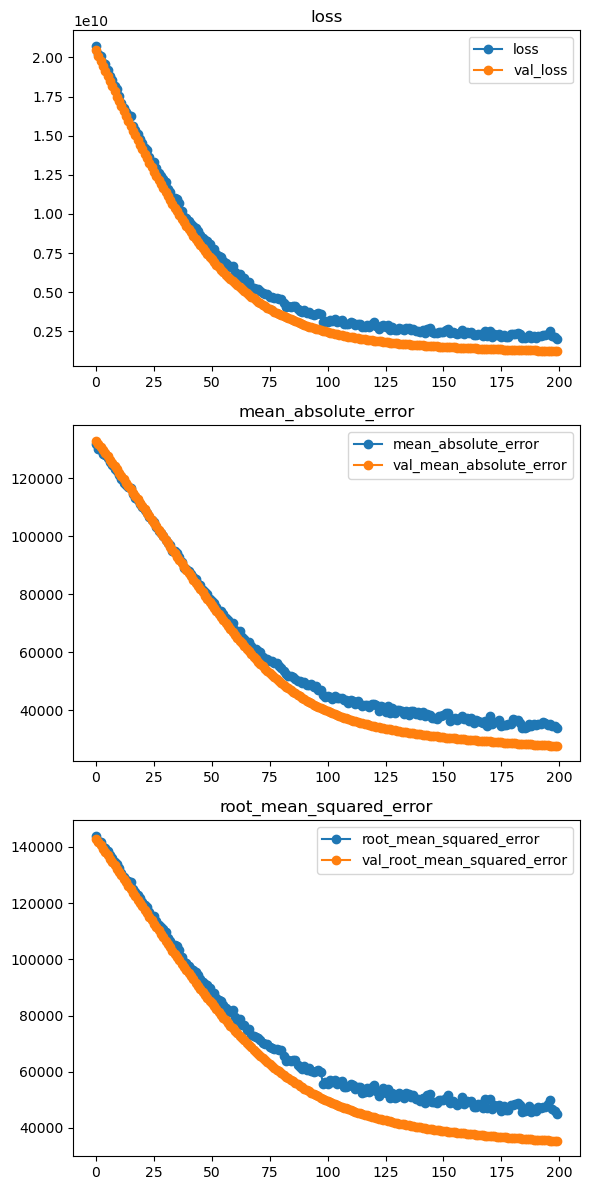

In [53]:
# plot learning 
plot_history(history);

In [54]:
# evaluate model
y_pred = reg_model.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

12/12 [==============================] - 0s 1ms/step
final RMSE: 46613.05772922416
final MAE: 28229.481357020548
final R2: 0.6067605864985681


## We used a "Follow the Regular Leader" optimizer for our third model, and while metrics were similar to our second model, it took twice as many epochs. We should stick with the adam and tune from there to optimize.